In [5]:
import sys
# add didgelab source code to path
sys.path.append('../../')

from cad.calc.parameters import MutationParameterSet, MutationParameter
from cad.ui.visualization import DidgeVisualizer
import numpy as np
from cad.calc.geo import Geo, geotools
import sys
import random

[(0.0, 32.0),
 (152.5, 32.000000405),
 (305.0, 32.00010368),
 (457.5, 32.002657205),
 (610.0, 32.02654208),
 (762.5, 32.158203125),
 (915.0, 32.68024448),
 (1067.5, 34.334744404999995),
 (1220.0, 38.794772480000006),
 (1372.5, 49.43392200500001),
 (1525.0, 72.5)]

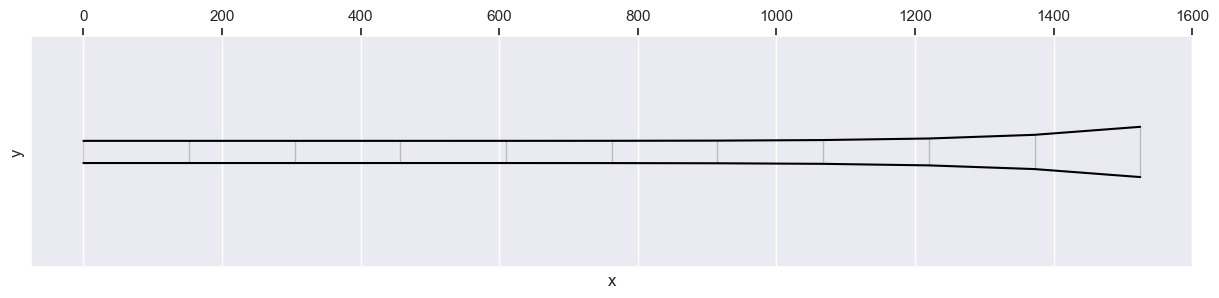

In [50]:
class SintraShape(MutationParameterSet):
    
    def __init__(self):
        
        MutationParameterSet.__init__(self)

        self.d1=32
        self.n_segments = 10
        
        self.add_param("length", 1450, 1600)
        self.add_param("bellsize", 65, 80)
        self.add_param("power", 1,3)
        
        

    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")

        x = length*np.arange(self.n_segments+1)/self.n_segments
    
        y= np.arange(self.n_segments+1)/self.n_segments
        p = self.get_value("power")
        y = np.power(y, p)
        y = np.power(y, p)
        y = np.power(y, p)
        y = self.d1 + y*(bellsize - self.d1)
        
        geo = list(zip(x,y))
        
        return Geo(geo)
        
shape = SintraShape()
geo = shape.make_geo()
DidgeVisualizer.vis_didge(geo)
geo.geo

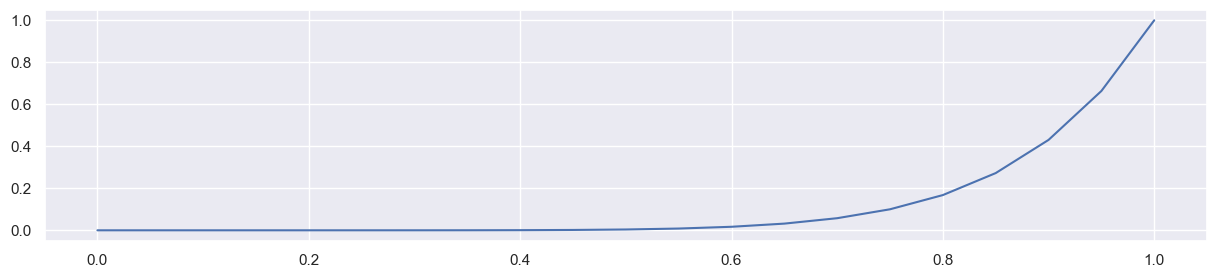

In [38]:
import matplotlib.pyplot as plt

n=20
x = np.arange(n+1)/n
y = np.power(x, 2)
y = np.power(y, 2)
y = np.power(y, 2)
#y = np.power(y, 2)
plt.plot(x,y)